# Project Overview

## Import Libraries

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

## Business Case/Problem

## Data Description

## Data Load

In [25]:
kc_house_data = pd.read_csv('data/kc_house_data.csv')

In [26]:
kc_house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [7]:
kc_house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Features to remove: 
- 'yr_renovated': large number of missing data.

## Data Cleaning

Let's review columns to see which ones make the most sense to keep.

In [10]:
kc_house_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [1]:
columns_to_keep = ['price', 
                   'bedrooms', 
                   'bathrooms', 
                   'sqft_living', 
                   'sqft_lot', 
                   'floors', 
                   'waterfront', 
                   'condition',
                  'grade',
                  'sqft_above',
                  'sqft_basement',
                  'yr_built',
                  'zipcode'
                  ]

In [27]:
def filter_columns(df):
    columns_to_keep = ['price', 
                   'bedrooms', 
                   'bathrooms', 
                   'sqft_living', 
                   'sqft_lot', 
                   'floors', 
                   'waterfront', 
                   'condition',
                  'grade',
                  'sqft_above',
                  'yr_built',
                  'zipcode'
                  ]
    return df[columns_to_keep]

In [28]:
house_data_filtered = filter_columns(kc_house_data)
house_data_filtered.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,zipcode
0,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1180,1955,98178
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,1951,98125
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,1933,98028
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,1965,98136
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,1987,98074


In [10]:
house_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   bedrooms     21597 non-null  int64  
 2   bathrooms    21597 non-null  float64
 3   sqft_living  21597 non-null  int64  
 4   sqft_lot     21597 non-null  int64  
 5   floors       21597 non-null  float64
 6   waterfront   19221 non-null  float64
 7   condition    21597 non-null  int64  
 8   grade        21597 non-null  int64  
 9   sqft_above   21597 non-null  int64  
 10  yr_built     21597 non-null  int64  
 11  zipcode      21597 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 2.0 MB


Missing data from 'waterfront' column will need to be addressed.

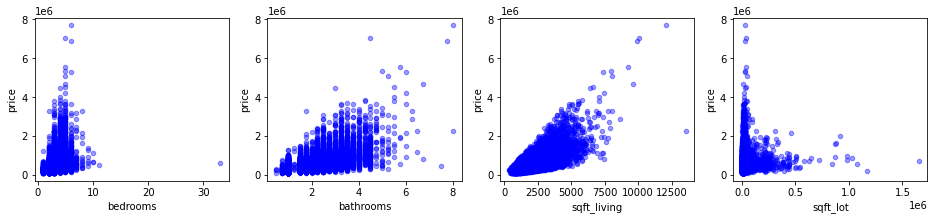

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['bedrooms', 
                     'bathrooms',
                     'sqft_living',
                     'sqft_lot', 
                     ], axes):
    house_data_filtered.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

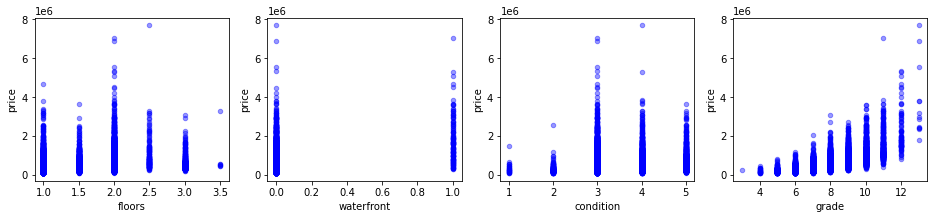

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['floors',
                     'waterfront',
                     'condition',
                     'grade'], axes):
    house_data_filtered.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

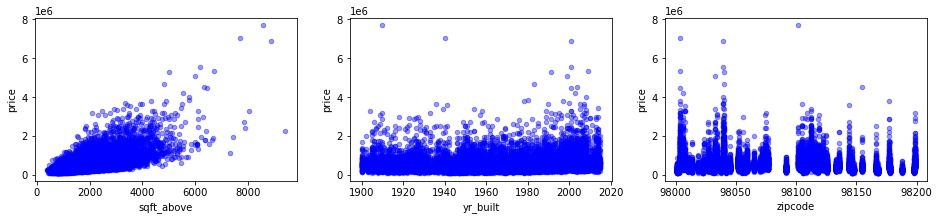

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(['sqft_above',
                    'yr_built',
                    'zipcode'], axes):
    house_data_filtered.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

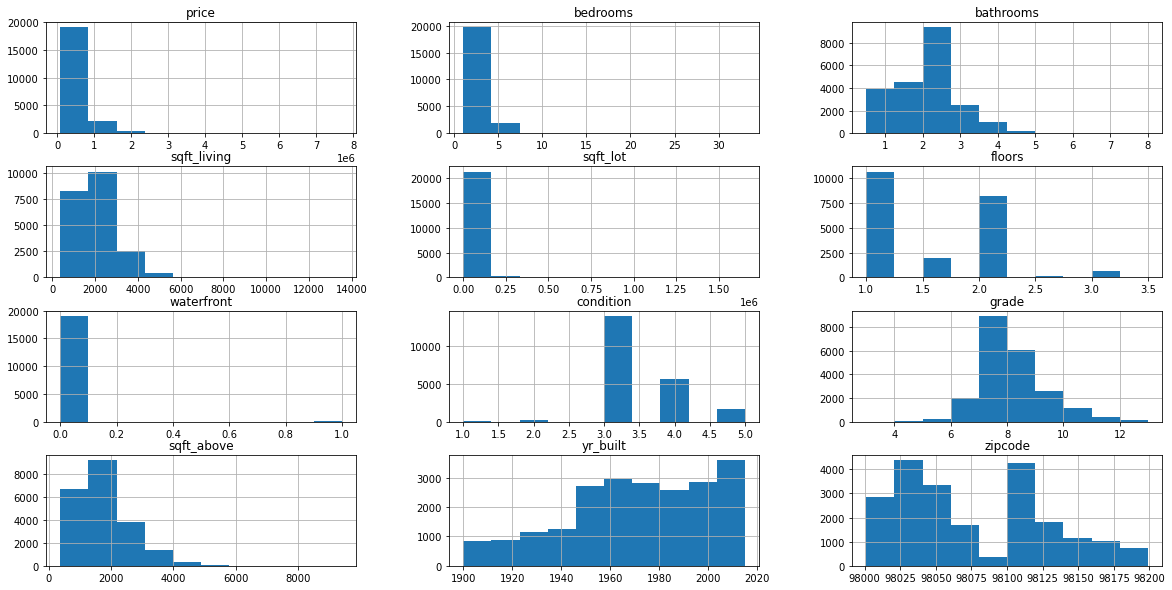

In [17]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
house_data_filtered.hist(ax = ax);

In [37]:
house_data_filtered['yr_built'] = house_data_filtered['yr_built'].astype('str')
house_data_filtered['zipcode'] = house_data_filtered['zipcode'].astype('str')

house_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   bedrooms     21597 non-null  int64  
 2   bathrooms    21597 non-null  float64
 3   sqft_living  21597 non-null  int64  
 4   sqft_lot     21597 non-null  int64  
 5   floors       21597 non-null  float64
 6   waterfront   19221 non-null  float64
 7   condition    21597 non-null  int64  
 8   grade        21597 non-null  int64  
 9   sqft_above   21597 non-null  int64  
 10  yr_built     21597 non-null  object 
 11  zipcode      21597 non-null  object 
dtypes: float64(4), int64(6), object(2)
memory usage: 2.0+ MB


In [28]:
house_data_filtered.waterfront.unique()

array([nan,  0.,  1.])

In [12]:
house_data_filtered.zipcode.unique()

array([98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198, 98146,
       98038, 98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133,
       98040, 98092, 98030, 98119, 98112, 98052, 98027, 98117, 98058,
       98001, 98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008,
       98059, 98122, 98144, 98004, 98005, 98034, 98075, 98116, 98010,
       98118, 98199, 98032, 98045, 98102, 98077, 98108, 98168, 98177,
       98065, 98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011,
       98031, 98106, 98072, 98188, 98014, 98055, 98039])

In [14]:
house_data_filtered.yr_built.unique()

array([1955, 1951, 1933, 1965, 1987, 2001, 1995, 1963, 1960, 2003, 1942,
       1927, 1977, 1900, 1979, 1994, 1916, 1921, 1969, 1947, 1968, 1985,
       1941, 1915, 1909, 1948, 2005, 1929, 1981, 1930, 1904, 1996, 2000,
       1984, 2014, 1922, 1959, 1966, 1953, 1950, 2008, 1991, 1954, 1973,
       1925, 1989, 1972, 1986, 1956, 2002, 1992, 1964, 1952, 1961, 2006,
       1988, 1962, 1939, 1946, 1967, 1975, 1980, 1910, 1983, 1978, 1905,
       1971, 2010, 1945, 1924, 1990, 1914, 1926, 2004, 1923, 2007, 1976,
       1949, 1999, 1901, 1993, 1920, 1997, 1943, 1957, 1940, 1918, 1928,
       1974, 1911, 1936, 1937, 1982, 1908, 1931, 1998, 1913, 2013, 1907,
       1958, 2012, 1912, 2011, 1917, 1932, 1944, 1902, 2009, 1903, 1970,
       2015, 1934, 1938, 1919, 1906, 1935])

Before going further we should keep a hold out set

In [11]:
target = house_data_filtered['price']
features = house_data_filtered.iloc[:,1:12]

X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.1)
X_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,zipcode
2525,4,2.25,1990,7712,1.0,0.0,3,8,1210,1973,98027
11701,3,1.00,1250,7015,1.0,0.0,3,7,1250,1958,98188
6200,4,1.00,1500,5750,1.5,0.0,3,6,1500,1925,98055
888,3,2.50,1940,10035,2.0,0.0,4,8,1940,1994,98072
4456,3,2.25,2210,11585,1.0,0.0,4,7,1510,1958,98155
...,...,...,...,...,...,...,...,...,...,...,...
3951,3,1.00,1000,9150,1.0,0.0,3,7,1000,1969,98059
20390,4,2.75,2260,5705,2.0,0.0,3,8,2260,2014,98042
15248,4,2.00,2680,18768,1.0,0.0,5,8,2680,1965,98001
13928,4,3.00,2390,7309,2.0,0.0,4,7,2390,1944,98002


## Model A

## Feature Engineering

## Model Training

## Model Evaluation

## Conclusions/Summary